# Traveling salesman using SA

Sergeev Valentin

## Implementation of algorithm and visualization

In [272]:
# !pip install basemap, basemap-data-hires

import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopy.distance as gdist
from matplotlib.pyplot import figure

class SA(object):
    def __init__(self, coords, alpha=0.995, stopping_T=1e-10, stopping_iter=100000):
        self.coords = coords
        self.N = coords.shape[0]
        self.T = math.sqrt(self.N)
        self.alpha = alpha
        self.stop_T = stopping_T
        self.stop_iteration = stopping_iter
        self.iteration = 1

        self.nodes = [i for i in range(self.N)]

        self.best_solution = None
        self.best_fit = float("Inf")
        self.fitness_list = []
        self.dist_cache = {}

    def initial_solution(self):
        solution = np.arange(0, self.N)

        return solution, self.fitness(solution)

    def dist(self, node_0, node_1):
        # since calculation of geodesic distance is heavy operation, lets cache it
        # It significantly increases performance
        if (node_0, node_1) in self.dist_cache:
            return self.dist_cache[(node_1, node_0)]

        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        dist = gdist.geodesic(coord_0, coord_1).km
        self.dist_cache[(node_0, node_1)] = dist
        self.dist_cache[(node_1, node_0)] = dist

        return dist

    def fitness(self, solution):
        accumulator = 0
        for i in range(self.N):
            current_node = solution[i % self.N]
            next_node = solution[(i + 1) % self.N]

            accumulator += self.dist(current_node, next_node)

        return accumulator

    def p_accept(self, candidate_fitness):
        """
        Simplified form of p(x') / p(xt) given then p(x) = e^(-dist/T)
        """
        return math.exp(-abs(candidate_fitness - self.cur_fit) / self.T)

    def accept(self, candidate):
        candidate_fit = self.fitness(candidate)

        # accept immediately if candidate is better
        if candidate_fit < self.cur_fit:
            self.cur_fit, self.cur_solution = candidate_fit, candidate
            if candidate_fit < self.best_fit:
                self.best_fit, self.best_solution = candidate_fit, candidate
        # exploration - maybe accept worse candidate
        elif random.random() < self.p_accept(candidate_fit):
                self.cur_fit, self.cur_solution = candidate_fit, candidate


    def anneal(self):
        self.cur_solution, self.cur_fit = self.initial_solution()

        while self.T >= self.stop_T and self.iteration < self.stop_iteration:
            candidate = list(self.cur_solution)

            i = random.randint(0, self.N - 1)
            j = random.randint(0, self.N - 1)

            candidate[i], candidate[j] = candidate[j], candidate[i]

            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1

            self.fitness_list.append(self.cur_fit)

        print("Best fitness: ", self.best_fit)
        
        initial_fut = self.fitness_list[0]
        improvement = 100 * (initial_fut - self.best_fit) / initial_fut
        print(f"Improvement over initial solution: {improvement : .2f}%")

    def visualize_route(self):
        path = self.best_solution
        points =self.coords

        figure(figsize=(16, 12))
        m = Basemap(projection='merc',llcrnrlat=40,urcrnrlat=75,
                    llcrnrlon=25, urcrnrlon=195,lat_ts=20,resolution='l')

        m.drawcountries(linewidth=2)
        m.drawcoastlines()
        m.fillcontinents(color='coral',lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')

        lats = []
        longs = []
        for i in path:
            lats.append(points[i][0])
            longs.append(points[i][1])

        initial_point = path[0]
        lats.append(points[initial_point][0])
        longs.append(points[initial_point][1])

        m.plot(longs, lats, marker = 'o', color='b', zorder=5, latlon=True)

        plt.show()

    def plot_scores(self):
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel("Fitness")
        plt.xlabel("Iteration")
        plt.show()

## Dataset

In [273]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("city.csv")

dataset = dataset.sort_values("population", ascending=False)
N = 30

longs = dataset["geo_lon"][:N]
lats = dataset["geo_lat"][:N]

coords = np.array((lats, longs)).T # get paired list

def anneal(sa: SA):
    sa.anneal()
    sa.visualize_route()
    sa.plot_scores()

dataset.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,NaN,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
786,г Санкт-Петербург,190000.0,Россия,Северо-Западный,г,Санкт-Петербург,NaN,NaN,NaN,NaN,...,1,0,40000000000,40000000,7800,UTC+3,59.939131,30.315900,4848742,1703
647,г Новосибирск,630000.0,Россия,Сибирский,обл,Новосибирская,NaN,NaN,г,Новосибирск,...,4,2,50401000000,50701000001,5400,UTC+7,55.028191,82.921149,1498921,1893
832,г Екатеринбург,620000.0,Россия,Уральский,обл,Свердловская,NaN,NaN,г,Екатеринбург,...,4,2,65401000000,65701000001,6600,UTC+5,56.838522,60.605491,1377738,1723
619,г Нижний Новгород,603000.0,Россия,Приволжский,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,...,4,2,22401000000,22701000001,5200,UTC+3,56.324063,44.005391,1250615,1221


## Comparison of annealing rate

### Slow cooling

Best fitness:  19783.785594054858
Improvement over initial solution:  69.73%


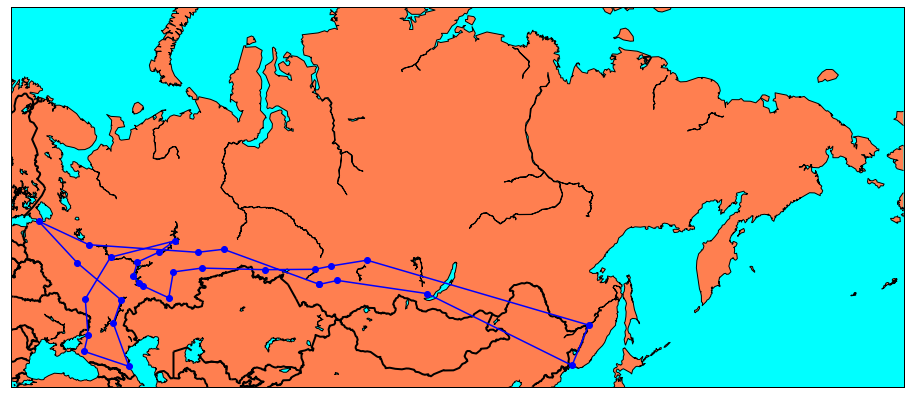

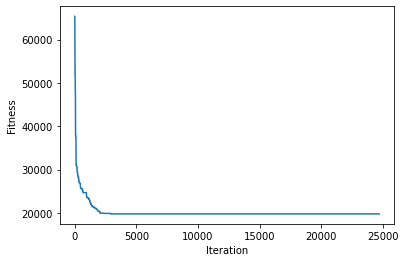

In [274]:
sa = SA(coords, alpha=0.999)
anneal(sa)

### Fast cooling

Best fitness:  34127.43758095409
Improvement over initial solution:  47.79%


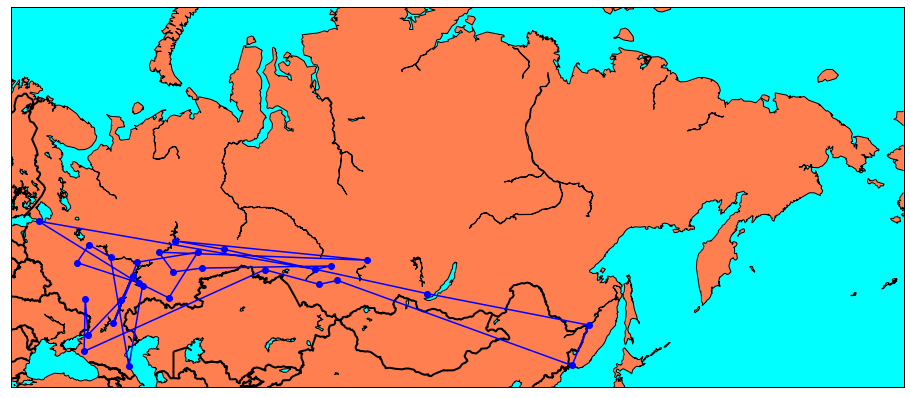

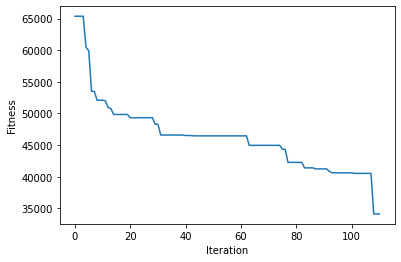

In [275]:
sa = SA(coords, alpha=0.8)
anneal(sa)

### Medium cooling

Best fitness:  25445.223857941262
Improvement over initial solution:  61.07%


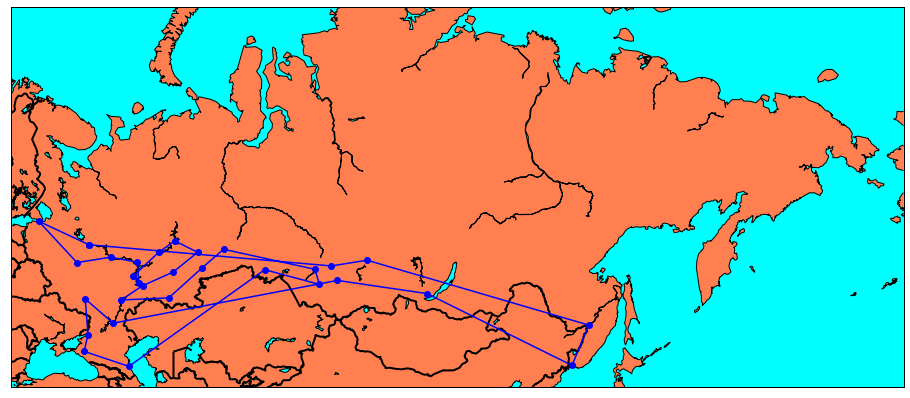

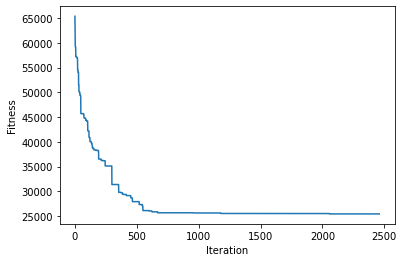

In [276]:
sa = SA(coords, alpha=0.99)
anneal(sa)

### Conclusion

As we can see, slow cooling performs best. That is due to fact that it performs more iterations until cooled down.
It also allows for more exploration, giving more chances to overcome local extrema

## Link to Github

https://github.com/ValentunSergeev/STD/blob/master/Assignment3.ipynb